Neste desafio, pedimos que você construa um modelo preditivo que responda à pergunta: “que tipo de pessoa tem mais probabilidade de sobreviver?” usando dados de passageiros (ou seja, nome, idade, sexo, classe socioeconômica, etc).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')



In [113]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [3]:
test = pd.read_csv('test.csv')

train = pd.read_csv('train.csv')


In [4]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Pegando a referencia do filme, onde a prioridade foram as mulheres e crianças. Precisamos trabalhar com a hipotese que no minimo todos os homens morreram no naufragio, se o modelo mostrar qualquer resultado diferente disso precisaremos rever.

Detalhamento das colunas: 

Id do passageiro, 
classe, Nome, Sexo, Idade,
SibSp = Nº de irmãos/cônjuges a bordo do Titanic, 
Parch = Nº de pais/filhos a bordo do Titanic
Tichet
Fare = Tarifa do passageiro
Cabin = Numero de Cabine
Embarked = Porto de embarcação = C = Cherbourg, Q = Queenstown, S = Southampton


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [10]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [11]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


Apos analise dos dados de teste e treino, notamos na base de treino uma coluna a mais que seria se o passageiro morreu ou sobreviveu, na base de test esta coluna não existe, pois é exatamenteo que o modelo precisa prever. 
Temos tambem nas duas bases dados faltantes que precisaremos tratar.


Iremos criar uma variavel para o ID passageiro, pois precisaremos usar essas informações no final do modelo.

In [12]:
PassengerId = test['PassengerId']


Como precisamos tratar a base de treino e teste da mesma forma, irei juntar os dois dataframe e realizar os tratamentos e depois separar novamente as bases de treino e teste.
Lembrando que a unica coluna que não iremos tratar será a coluna de Survived(Sobrevivente) pois essa deveremos deixar vazia na base de teste.

Documentando a quantidade de linhas na base de treino e coluna:

Train = 891

test = 418

In [13]:
titanic_df = train.append(test, ignore_index= True)

titanic_df

C:\Users\Micro\AppData\Local\Temp\ipykernel_10816\707762550.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  titanic_df = train.append(test, ignore_index= True)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [14]:
titanic_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Vou criar um novo dataFrame, para que eu possa ir adicionando as colunas para realizar o treino no modelo.

In [15]:
df = pd.DataFrame()

Criando uma função com as principais analises que precisamos realizar antes dos tratamentos das colunas, essa função precisamos passar o dataframe, coluna e o count esta sendo tratadado como True, nesse caso não precisamos passar nenhuma dado, apenas passaremos dados quando for precisorealizar outra analise.

In [16]:
def titanic_fun(data, column, count=True):
    print(f'quantidade de valores unicos: {data[column].nunique()}')
    print(f'/quais são os valores unicos: {data[column].unique()}')
    print(f'/quais são os valores nulos: {data[column].isnull().sum()}')
    print(f'/quantidade por opção: {data[column].value_counts()}')

    if count ==True:
        sns.countplot(data = data, x= column, hue='Survived')
    else:
        sns.displot(data[column], kde= True)



# A partir desse ponto iremos analisar e tratar coluna a coluna.

### Survived

quantidade de valores unicos: 2
/quais são os valores unicos: [ 0.  1. nan]
/quais são os valores nulos: 418
/quantidade por opção: 0.0    549
1.0    342
Name: Survived, dtype: int64


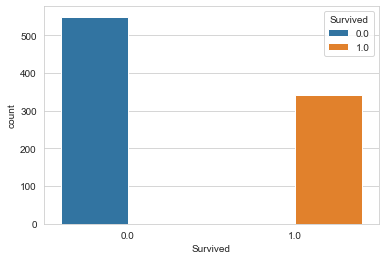

In [17]:
titanic_fun(titanic_df, 'Survived')

Realizado a analise na coluna Survived e não temos nenhum tratamento a ser feito, neste caso iremos adicionar essa coluna no nosso novo df, conforme os codigos abaixo.

In [18]:
df['Survived'] = titanic_df['Survived']

df

,Survived
0,0.0
1,1.0
2,1.0
3,1.0
4,0.0
...,...
1304,NaN
1305,NaN
1306,NaN
1307,NaN


## Pclass

quantidade de valores unicos: 3
/quais são os valores unicos: [3 1 2]
/quais são os valores nulos: 0
/quantidade por opção: 3    709
1    323
2    277
Name: Pclass, dtype: int64


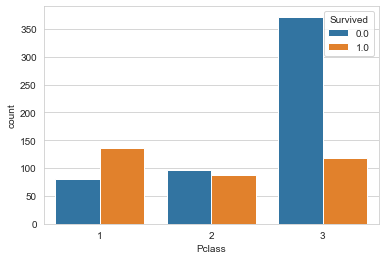

In [19]:
titanic_fun(titanic_df, 'Pclass')

In [21]:
df['Pclass'] = titanic_df['Pclass']

# Sex

quantidade de valores unicos: 2
/quais são os valores unicos: ['male' 'female']
/quais são os valores nulos: 0
/quantidade por opção: male      843
female    466
Name: Sex, dtype: int64


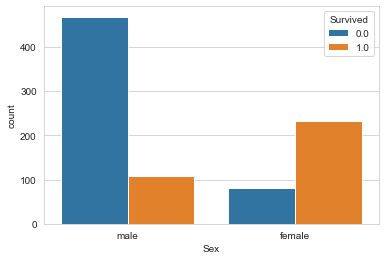

In [22]:
titanic_fun(titanic_df, 'Sex')

Neste caso precisaremos substituir o male e female por 0, 1, dessa forma facilita a interpretação do modelo.

In [23]:
titanic_df['Sex'] = titanic_df['Sex'].replace(['male', 'female'], [0, 1])

In [24]:
df['Sex'] = titanic_df['Sex']

# Age

quantidade de valores unicos: 98
/quais são os valores unicos: [22.   38.   26.   35.     nan 54.    2.   27.   14.    4.   58.   20.
 39.   55.   31.   34.   15.   28.    8.   19.   40.   66.   42.   21.
 18.    3.    7.   49.   29.   65.   28.5   5.   11.   45.   17.   32.
 16.   25.    0.83 30.   33.   23.   24.   46.   59.   71.   37.   47.
 14.5  70.5  32.5  12.    9.   36.5  51.   55.5  40.5  44.    1.   61.
 56.   50.   36.   45.5  20.5  62.   41.   52.   63.   23.5   0.92 43.
 60.   10.   64.   13.   48.    0.75 53.   57.   80.   70.   24.5   6.
  0.67 30.5   0.42 34.5  74.   22.5  18.5  67.   76.   26.5  60.5  11.5
  0.33  0.17 38.5 ]
/quais são os valores nulos: 263
/quantidade por opção: 24.0    47
22.0    43
21.0    41
30.0    40
18.0    39
        ..
23.5     1
70.5     1
55.5     1
20.5     1
38.5     1
Name: Age, Length: 98, dtype: int64


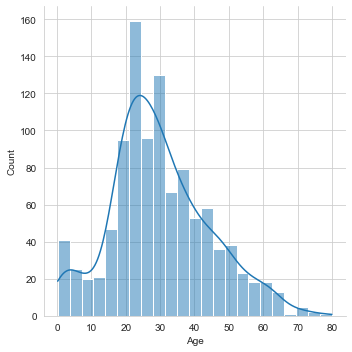

In [25]:
titanic_fun(titanic_df, 'Age', False)

Nesta coluna temos uma quantidade bem consideravel de null, beste caso vamos verificar com variavel se correlaciona mais com idade para encontrarmos uma valor pra preenchermos essas informaçoes vazia.

In [26]:
titanic_df.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.038354,-0.013406,0.028814,-0.055224,0.008942,0.031428
Survived,-0.005007,1.000000,-0.338481,0.543351,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.038354,-0.338481,1.000000,-0.124617,-0.408106,0.060832,0.018322,-0.558629
Sex,-0.013406,0.543351,-0.124617,1.000000,-0.063645,0.109609,0.213125,0.185523
Age,0.028814,-0.077221,-0.408106,-0.063645,1.000000,-0.243699,-0.150917,0.178740
SibSp,-0.055224,-0.035322,0.060832,0.109609,-0.243699,1.000000,0.373587,0.160238
Parch,0.008942,0.081629,0.018322,0.213125,-0.150917,0.373587,1.000000,0.221539
Fare,0.031428,0.257307,-0.558629,0.185523,0.178740,0.160238,0.221539,1.000000


Identifiquei que a maior correlação com a idade é a Pclass, neste caso vamos verificar qual era a media de idade por classe.

In [30]:
for i in sorted(titanic_df['Pclass'].unique()):
    tita = titanic_df[titanic_df['Pclass']== i]['Age'].mean()
    print('Pessoas da {} classe te a media de idade de: {:.2f}'.format(i, tita))

Pessoas da 1 classe te a media de idade de: 39.16
Pessoas da 2 classe te a media de idade de: 29.51
Pessoas da 3 classe te a media de idade de: 24.82


Agora irei usar a função FILLNA, nas linhas que estão vazias, usando a media de idade conforme a clase de cada passageiro.

In [31]:
titanic_df['Age'].isnull().sum()

263

In [32]:
for i in titanic_df.index:
    if pd.isnull(titanic_df['Age'][i]):
        if titanic_df['Pclass'][i] == 1:
            titanic_df['Age'][i] = round(titanic_df[titanic_df['Pclass'] == 1]['Age'].mean())
        elif titanic_df['Pclass'][i] == 2:
            titanic_df['Age'][i] = round(titanic_df[titanic_df['Pclass'] == 2]['Age'].mean())
        elif titanic_df['Pclass'][i] == 3:
            titanic_df['Age'][i] = round(titanic_df[titanic_df['Pclass'] == 3]['Age'].mean())
    else:
        continue

C:\Users\Micro\AppData\Local\Temp\ipykernel_10816\3951301631.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_df['Age'][i] = round(titanic_df[titanic_df['Pclass'] == 3]['Age'].mean())
C:\Users\Micro\AppData\Local\Temp\ipykernel_10816\3951301631.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_df['Age'][i] = round(titanic_df[titanic_df['Pclass'] == 2]['Age'].mean())
C:\Users\Micro\AppData\Local\Temp\ipykernel_10816\3951301631.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [33]:
titanic_df['Age'].isnull().sum()

0

In [34]:
df['Age'] = titanic_df['Age']

In [35]:
df.isnull().sum()

Survived    418
Pclass        0
Sex           0
Age           0
dtype: int64

# SibSP

quantidade de valores unicos: 7
/quais são os valores unicos: [1 0 3 4 2 5 8]
/quais são os valores nulos: 0
/quantidade por opção: 0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: SibSp, dtype: int64


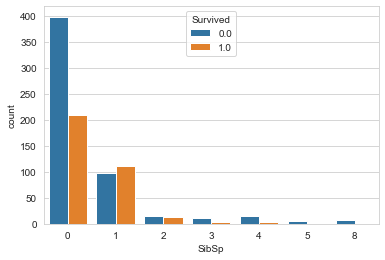

In [36]:
titanic_fun(titanic_df, 'SibSp')

In [37]:
df['SibSp'] = titanic_df['SibSp']

# Parch (filho, filha, pais)

quantidade de valores unicos: 8
/quais são os valores unicos: [0 1 2 5 3 4 6 9]
/quais são os valores nulos: 0
/quantidade por opção: 0    1002
1     170
2     113
3       8
5       6
4       6
6       2
9       2
Name: Parch, dtype: int64


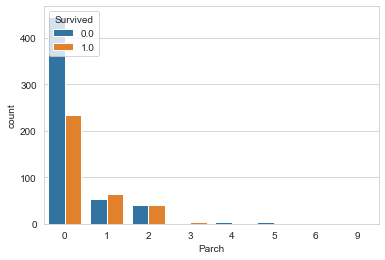

In [38]:
titanic_fun(titanic_df, 'Parch')

In [39]:
df['Parch'] = titanic_df['Parch']

Vamos criar uma nova coluna somando o SibSP e Parch como pessoas da familia.

# FamilySize

In [40]:
df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1

In [41]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,FamilySize
0,0.0,3,0,22.0,1,0,2
1,1.0,1,1,38.0,1,0,2
2,1.0,3,1,26.0,0,0,1
3,1.0,1,1,35.0,1,0,2
4,0.0,3,0,35.0,0,0,1
...,...,...,...,...,...,...,...
1304,NaN,3,0,25.0,0,0,1
1305,NaN,1,1,39.0,0,0,1
1306,NaN,3,0,38.5,0,0,1
1307,NaN,3,0,25.0,0,0,1


quantidade de valores unicos: 9
/quais são os valores unicos: [ 2  1  5  3  7  6  4  8 11]
/quais são os valores nulos: 0
/quantidade por opção: 1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: FamilySize, dtype: int64


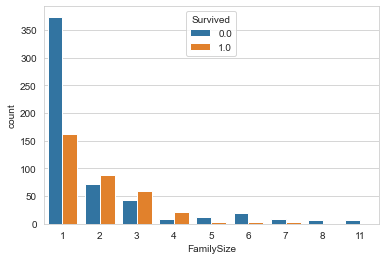

In [42]:
titanic_fun(df, 'FamilySize')

## Fare

quantidade de valores unicos: 281
/quais são os valores unicos: [  7.25    71.2833   7.925   53.1      8.05     8.4583  51.8625  21.075
  11.1333  30.0708  16.7     26.55    31.275    7.8542  16.      29.125
  13.      18.       7.225   26.       8.0292  35.5     31.3875 263.
   7.8792   7.8958  27.7208 146.5208   7.75    10.5     82.1708  52.
   7.2292  11.2417   9.475   21.      41.5792  15.5     21.6792  17.8
  39.6875   7.8     76.7292  61.9792  27.75    46.9     80.      83.475
  27.9     15.2458   8.1583   8.6625  73.5     14.4542  56.4958   7.65
  29.      12.475    9.       9.5      7.7875  47.1     15.85    34.375
  61.175   20.575   34.6542  63.3583  23.      77.2875   8.6542   7.775
  24.15     9.825   14.4583 247.5208   7.1417  22.3583   6.975    7.05
  14.5     15.0458  26.2833   9.2167  79.2      6.75    11.5     36.75
   7.7958  12.525   66.6      7.3125  61.3792   7.7333  69.55    16.1
  15.75    20.525   55.      25.925   33.5     30.6958  25.4667  28.7125
   0.      1

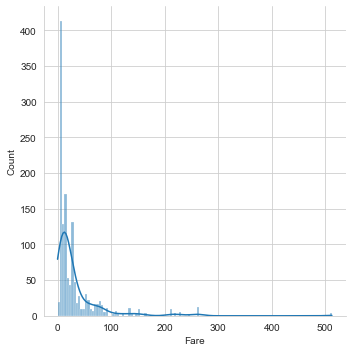

In [43]:
titanic_fun(titanic_df, 'Fare', False)

In [44]:
titanic_df[titanic_df['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,NaN,3,"Storey, Mr. Thomas",0,60.5,0,0,3701,NaN,NaN,S


In [45]:
titanic_df[titanic_df['Pclass'] == 3]['Fare'].mean()

13.302888700564973

In [46]:
titanic_df['Fare'].fillna(13, inplace=True)

In [47]:
titanic_df.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          2
dtype: int64

In [48]:
df['Fare'] = titanic_df['Fare']

# Cabin

quantidade de valores unicos: 186
/quais são os valores unicos: [nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 

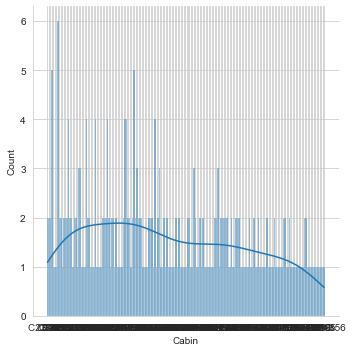

In [49]:
titanic_fun(titanic_df, 'Cabin', False)

Neste momento irei deixar os dados da 'Cabin' de fora, pois temos 90% dos dados nulo. Futuramente podemos pensar em algo para considerar esses daodos, pois podemos tentar preve com os numeros das cabines qual era a distancia para os botes salvavidas.

# Embarked

quantidade de valores unicos: 3
/quais são os valores unicos: ['S' 'C' 'Q' nan]
/quais são os valores nulos: 2
/quantidade por opção: S    914
C    270
Q    123
Name: Embarked, dtype: int64


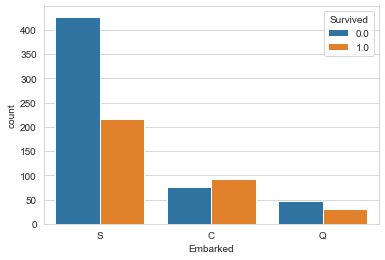

In [50]:
titanic_fun(titanic_df, 'Embarked')

In [51]:
titanic_df[titanic_df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",1,38.0,0,0,113572,80.0,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,62.0,0,0,113572,80.0,B28,NaN


In [52]:
titanic_df[titanic_df["Embarked"] == 'S']['Survived'].mean()


0.33695652173913043

In [53]:
titanic_df[titanic_df["Embarked"] == 'C']['Survived'].mean()

0.5535714285714286

In [54]:
titanic_df[titanic_df["Embarked"] == 'Q']['Survived'].mean()

0.38961038961038963

In [55]:
titanic_df[titanic_df["Embarked"] == 'Q']['Pclass'].mean()

2.894308943089431

In [56]:
titanic_df['Embarked'].fillna('C', inplace=True)

In [57]:
df['Embarked'] = titanic_df['Embarked']

df

,Survived,Pclass,Sex,Age,SibSp,Parch,FamilySize,Fare,Embarked
0,0.0,3,0,22.0,1,0,2,7.2500,S
1,1.0,1,1,38.0,1,0,2,71.2833,C
2,1.0,3,1,26.0,0,0,1,7.9250,S
3,1.0,1,1,35.0,1,0,2,53.1000,S
4,0.0,3,0,35.0,0,0,1,8.0500,S
...,...,...,...,...,...,...,...,...,...
1304,NaN,3,0,25.0,0,0,1,8.0500,S
1305,NaN,1,1,39.0,0,0,1,108.9000,C
1306,NaN,3,0,38.5,0,0,1,7.2500,S
1307,NaN,3,0,25.0,0,0,1,8.0500,S


# Name

In [58]:
titanic_df['Name'].iloc[0].split(' ')

['Braund,', 'Mr.', 'Owen', 'Harris']

In [59]:
titanic_df['Tipo'] = titanic_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [60]:
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Tipo
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",0,25.0,0,0,A.5. 3236,8.0500,NaN,S,Mr
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",1,39.0,0,0,PC 17758,108.9000,C105,C,Dona
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",0,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Mr
1307,1308,NaN,3,"Ware, Mr. Frederick",0,25.0,0,0,359309,8.0500,NaN,S,Mr


In [61]:
titanic_df['Tipo'].nunique() # quantos titulos diferente nos temos

18

In [62]:
titanic_df['Tipo'].unique()#quais são os nomes das info

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [63]:
titanic_df['Tipo'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Tipo, dtype: int64

In [64]:
titanic_df['Tipo'] = [n if n in ['Mr', 'Miss', 'Mrs', 'Master'] else 'person' for n in titanic_df['Tipo']]

In [65]:
titanic_df['Tipo'].value_counts()

Mr        757
Miss      260
Mrs       197
Master     61
person     34
Name: Tipo, dtype: int64

quantidade de valores unicos: 5
/quais são os valores unicos: ['Mr' 'Mrs' 'Miss' 'Master' 'person']
/quais são os valores nulos: 0
/quantidade por opção: Mr        757
Miss      260
Mrs       197
Master     61
person     34
Name: Tipo, dtype: int64


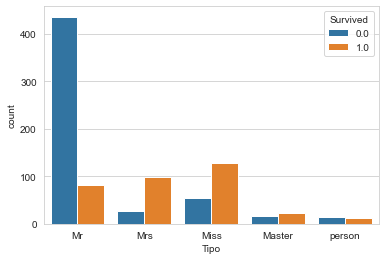

In [66]:
titanic_fun(titanic_df, 'Tipo')

In [67]:
df['Tipo'] = titanic_df['Tipo']

In [68]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,FamilySize,Fare,Embarked,Tipo
0,0.0,3,0,22.0,1,0,2,7.2500,S,Mr
1,1.0,1,1,38.0,1,0,2,71.2833,C,Mrs
2,1.0,3,1,26.0,0,0,1,7.9250,S,Miss
3,1.0,1,1,35.0,1,0,2,53.1000,S,Mrs
4,0.0,3,0,35.0,0,0,1,8.0500,S,Mr
...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,0,25.0,0,0,1,8.0500,S,Mr
1305,NaN,1,1,39.0,0,0,1,108.9000,C,person
1306,NaN,3,0,38.5,0,0,1,7.2500,S,Mr
1307,NaN,3,0,25.0,0,0,1,8.0500,S,Mr


### Tratamento das variaveis categorica

In [77]:
pclass = pd.get_dummies(df['Pclass'], prefix= 'Pclass', drop_first= True) #Esse comando crou 3 novas colunas separando as classes em 1, 2, 3, sendo 0 não pertence aquela classe e 1 pertecendo.
tipo = pd.get_dummies(df['Tipo'], prefix= 'Tipo', drop_first= True)
Embarked = pd.get_dummies(df['Embarked'], prefix= 'Embarked', drop_first= True)

In [78]:
Titanic_final = pd.concat([df, pclass, tipo, Embarked], axis=1)
Titanic_final


,Survived,Pclass,Sex,Age,SibSp,Parch,FamilySize,Fare,Embarked,Tipo,Pclass_2,Pclass_3,Tipo_Miss,Tipo_Mr,Tipo_Mrs,Tipo_person,Embarked_Q,Embarked_S
0,0.0,3,0,22.0,1,0,2,7.2500,S,Mr,0,1,0,1,0,0,0,1
1,1.0,1,1,38.0,1,0,2,71.2833,C,Mrs,0,0,0,0,1,0,0,0
2,1.0,3,1,26.0,0,0,1,7.9250,S,Miss,0,1,1,0,0,0,0,1
3,1.0,1,1,35.0,1,0,2,53.1000,S,Mrs,0,0,0,0,1,0,0,1
4,0.0,3,0,35.0,0,0,1,8.0500,S,Mr,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,0,25.0,0,0,1,8.0500,S,Mr,0,1,0,1,0,0,0,1
1305,NaN,1,1,39.0,0,0,1,108.9000,C,person,0,0,0,0,0,1,0,0
1306,NaN,3,0,38.5,0,0,1,7.2500,S,Mr,0,1,0,1,0,0,0,1
1307,NaN,3,0,25.0,0,0,1,8.0500,S,Mr,0,1,0,1,0,0,0,1


In [80]:
Titanic_final.drop(['Pclass', 'Embarked', 'Tipo'], axis=1, inplace= True)

In [81]:
Titanic_final

,Survived,Sex,Age,SibSp,Parch,FamilySize,Fare,Pclass_2,Pclass_3,Tipo_Miss,Tipo_Mr,Tipo_Mrs,Tipo_person,Embarked_Q,Embarked_S
0,0.0,0,22.0,1,0,2,7.2500,0,1,0,1,0,0,0,1
1,1.0,1,38.0,1,0,2,71.2833,0,0,0,0,1,0,0,0
2,1.0,1,26.0,0,0,1,7.9250,0,1,1,0,0,0,0,1
3,1.0,1,35.0,1,0,2,53.1000,0,0,0,0,1,0,0,1
4,0.0,0,35.0,0,0,1,8.0500,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,0,25.0,0,0,1,8.0500,0,1,0,1,0,0,0,1
1305,NaN,1,39.0,0,0,1,108.9000,0,0,0,0,0,1,0,0
1306,NaN,0,38.5,0,0,1,7.2500,0,1,0,1,0,0,0,1
1307,NaN,0,25.0,0,0,1,8.0500,0,1,0,1,0,0,0,1


In [82]:
train_df = Titanic_final.iloc[:891]

In [83]:
test_df = Titanic_final.iloc[891:]

In [84]:
train_df

,Survived,Sex,Age,SibSp,Parch,FamilySize,Fare,Pclass_2,Pclass_3,Tipo_Miss,Tipo_Mr,Tipo_Mrs,Tipo_person,Embarked_Q,Embarked_S
0,0.0,0,22.0,1,0,2,7.2500,0,1,0,1,0,0,0,1
1,1.0,1,38.0,1,0,2,71.2833,0,0,0,0,1,0,0,0
2,1.0,1,26.0,0,0,1,7.9250,0,1,1,0,0,0,0,1
3,1.0,1,35.0,1,0,2,53.1000,0,0,0,0,1,0,0,1
4,0.0,0,35.0,0,0,1,8.0500,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,0,27.0,0,0,1,13.0000,1,0,0,0,0,1,0,1
887,1.0,1,19.0,0,0,1,30.0000,0,0,1,0,0,0,0,1
888,0.0,1,25.0,1,2,4,23.4500,0,1,1,0,0,0,0,1
889,1.0,0,26.0,0,0,1,30.0000,0,0,0,1,0,0,0,0


In [85]:
test_df

,Survived,Sex,Age,SibSp,Parch,FamilySize,Fare,Pclass_2,Pclass_3,Tipo_Miss,Tipo_Mr,Tipo_Mrs,Tipo_person,Embarked_Q,Embarked_S
891,NaN,0,34.5,0,0,1,7.8292,0,1,0,1,0,0,1,0
892,NaN,1,47.0,1,0,2,7.0000,0,1,0,0,1,0,0,1
893,NaN,0,62.0,0,0,1,9.6875,1,0,0,1,0,0,1,0
894,NaN,0,27.0,0,0,1,8.6625,0,1,0,1,0,0,0,1
895,NaN,1,22.0,1,1,3,12.2875,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,NaN,0,25.0,0,0,1,8.0500,0,1,0,1,0,0,0,1
1305,NaN,1,39.0,0,0,1,108.9000,0,0,0,0,0,1,0,0
1306,NaN,0,38.5,0,0,1,7.2500,0,1,0,1,0,0,0,1
1307,NaN,0,25.0,0,0,1,8.0500,0,1,0,1,0,0,0,1


In [86]:
train_df['Survived'] = train_df['Survived'].astype(int)

C:\Users\Micro\AppData\Local\Temp\ipykernel_10816\2924566918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Survived'] = train_df['Survived'].astype(int)


In [89]:
#Separando as informações da base de treino, onde x é o DF exceto a coluna sobrevivente, e y é apenas a coluna sobrevivente. 
x = train_df.drop('Survived', axis= 1)
y = train_df['Survived']

In [95]:
#Preparando  a base de teste sem a coluna de sobrevivente, pois essa informação que o modelo precisa prever. 
x_teste = test_df.drop('Survived', axis=1)

x_teste

,Sex,Age,SibSp,Parch,FamilySize,Fare,Pclass_2,Pclass_3,Tipo_Miss,Tipo_Mr,Tipo_Mrs,Tipo_person,Embarked_Q,Embarked_S
891,0,34.5,0,0,1,7.8292,0,1,0,1,0,0,1,0
892,1,47.0,1,0,2,7.0000,0,1,0,0,1,0,0,1
893,0,62.0,0,0,1,9.6875,1,0,0,1,0,0,1,0
894,0,27.0,0,0,1,8.6625,0,1,0,1,0,0,0,1
895,1,22.0,1,1,3,12.2875,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,25.0,0,0,1,8.0500,0,1,0,1,0,0,0,1
1305,1,39.0,0,0,1,108.9000,0,0,0,0,0,1,0,0
1306,0,38.5,0,0,1,7.2500,0,1,0,1,0,0,0,1
1307,0,25.0,0,0,1,8.0500,0,1,0,1,0,0,0,1


A partir de agora iremos processar divermos modelos de MI.

In [96]:
#Criand uma função com varios modelos

def func_modelos(algoritmo, x_train, y_train, validacao):
    modelo = algoritmo.fit(x_train, y_train)
    acuracia = round(modelo.score(x_train, y_train)* 100, 2)

    train_pred = model_selection.cross_val_predict(algoritmo, x_train, y_train, cv = validacao, n_jobs= -1)
    acuracia_vc = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)

    return acuracia, acuracia_vc

In [99]:
# Random Forest

acuracia_randomForest, acuracia_vc_randomForest = func_modelos(RandomForestClassifier(), x, y, 10)

print('Acuracia: {}'.format(acuracia_randomForest))
print('Acuracia validação cruzada: {}'.format(acuracia_vc_randomForest))

Acuracia: 98.32
Acuracia validação cruzada: 80.7


In [100]:
#Logistic Regression

acuracia_log, acuracia_vc_log = func_modelos(LogisticRegression(max_iter= 1000), x, y, 10)

print('Acuracia_Regression: {}'.format(acuracia_log))
print('Acuracia validação cruzada_Regression: {}'.format(acuracia_vc_log))

Acuracia_Regression: 82.94
Acuracia validação cruzada_Regression: 82.38


In [105]:
# K-Nearest Neighbours

acuracia_Nei, acuracia_vc_Nei = func_modelos(KNeighborsClassifier(), x, y, 10)

print('Acuracia: {}'.format(acuracia_Nei))
print('Acuracia validação cruzada: {}'.format(acuracia_vc_Nei))

Acuracia: 80.81
Acuracia validação cruzada: 72.39


In [106]:
#Gaussian Naive Bayes

acuracia_bayes, acuracia_vc_bayes = func_modelos(GaussianNB(), x, y, 10)

print('Acuracia: {}'.format(acuracia_bayes))
print('Acuracia validação cruzada: {}'.format(acuracia_vc_bayes))

Acuracia_Regression: 78.79
Acuracia validação cruzada_Regression: 78.56


In [107]:
# Linear suport Vector Machines (SVC)

acuracia_svc, acuracia_vc_svc = func_modelos(LinearSVC(dual=False), x, y, 10)

print('Acuracia: {}'.format(acuracia_svc))
print('Acuracia validação cruzada: {}'.format(acuracia_vc_svc))

Acuracia: 83.28
Acuracia validação cruzada: 82.72


In [108]:
# Stochastic Gradient Descent

acuracia_sto, acuracia_vc_sto = func_modelos(SGDClassifier(), x, y, 10)

print('Acuracia: {}'.format(acuracia_sto))
print('Acuracia validação cruzada: {}'.format(acuracia_vc_sto))

Acuracia: 79.91
Acuracia validação cruzada: 68.91


In [109]:
# Decision tree Classifiers

acuracia_dt, acuracia_vc_dt = func_modelos(DecisionTreeClassifier(), x, y, 10)

print('Acuracia: {}'.format(acuracia_dt))
print('Acuracia validação cruzada: {}'.format(acuracia_vc_dt))

Acuracia: 98.32
Acuracia validação cruzada: 78.23


In [110]:
# Gradiente Boost Classifier

acuracia_gbt, acuracia_vc_gbt = func_modelos(GradientBoostingClassifier(), x, y, 10)

print('Acuracia: {}'.format(acuracia_gbt))
print('Acuracia validação cruzada: {}'.format(acuracia_vc_gbt))

Acuracia: 89.67
Acuracia validação cruzada: 83.28


### Melhor modelo de treino foi o Gradient Boost Trees

In [111]:
params = dict(
    max_depth = [n for n in range(1, 5)],
    min_samples_split = [n for n in range(2, 6)],
    min_samples_leaf = [n for n in range(2, 6)],
    n_estimators = [n for n in range(10, 50, 10)]
    
)

In [112]:
gbc = GradientBoostingClassifier()

In [114]:
gbc_vc = GridSearchCV(estimator= gbc, param_grid= params, cv= 10)

In [115]:
gbc_vc.fit(x, y)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [10, 20, 30, 40]})

In [121]:
print('Melhor Acuracia {:.2f}'.format(gbc_vc.best_score_))
print('Melhores Parametros {}'.format(gbc_vc.best_estimator_))

Melhor Acuracia 0.85
Melhores Parametros GradientBoostingClassifier(max_depth=4, min_samples_leaf=2, min_samples_split=4,
                           n_estimators=30)


In [122]:
#Hora de testar 

GradientBoostingClassifier_pred = gbc_vc.predict(x_teste)

In [124]:
kaggle = pd.DataFrame({'PassengerId': PassengerId, 'Survived': GradientBoostingClassifier_pred })

kaggle.to_csv('Titanic_Boosting_pred_csv', index=False)

In [125]:
kaggle

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
